# Isotherm processing

This notebook will perform the following:

- process previously selected isotherms to generate missing KPI
- build and save a pandas DataFrame consisting of KPI and basic isotherm parameters
- save trimmed down version of isotherms as an on-disc accessible dictionary (for dashboard access)
- show examples of how the processing to remove outliers and obtain a single value and confidence range for material-adsorbate pairs

To run this notebook the root directory must be the main folder.

In [2]:
import json
import pathlib
import pickle
from collections import Counter

from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
from cycler import cycler
import numpy as np
import pandas as pd

import pygaps

In [192]:
# Database location
db_path = pathlib.Path.cwd() / "data" / "iso.db"

# Get all isotherms
isotherms = pygaps.db_get_isotherms(db_path, {})

print(f'Loaded {len(isotherms)} isotherms.')

Selected20913isotherms
Loaded 20913 isotherms.


Compute uptake values on pre-determined pressures. Do not extrapolate above maximum range. If any value below minimum range, use Henry constant to compute loading.

In [30]:
no_loading_possible = []
model_possible = []

for iso in tqdm(isotherms):

    iso.uptake = {}

    prange = np.arange(0.5, 20.5, 0.5)
    minp = min(iso.pressure(branch='ads'))
    maxp = max(iso.pressure(branch='ads'))
    model = [a for a in prange if a < minp]
    direct = [a for a in prange if minp < a < maxp]

    try:
        for p in direct:
            iso.uptake[p] = np.asscalar(iso.loading_at(p))
    except Exception:
        no_loading_possible.append(iso)
        continue
    # Take the data between 0 and x from the henry model
    if model:
        for p in model:
            iso.uptake[p] = np.exp(iso.henry_k) * p
        model_possible.append(iso)

    iso.uptake[0] = 0.  # we automatically include 0

0%|          | 0/20913 [00:00<?, ?it/s]C:\Users\pauli\Miniconda3\envs\dscience\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  app.launch_new_instance()
100%|██████████| 20913/20913 [01:53<00:00, 183.56it/s]


The calculated KPI are saved in a separate table in a HDF5 database. This will allow very fast retrieval when the dashboard is operated.

In [31]:
simple_dict = {}

for iso in tqdm(isotherms):

    addition = {
        'mat' : iso.material,
        'ads' : str(iso.adsorbate),
        't' : iso.temperature,
        'type' : iso.iso_type,
        'kH' : np.log(iso.henry_k),
    }
    for p in np.arange(0.5, 20.5, 0.5):

        addition[str(int(2 * p))] = iso.uptake.get(p, None)

    simple_dict[iso.filename] = addition

df = pd.DataFrame.from_dict(simple_dict, orient='index')
df.to_hdf(pathlib.Path.cwd() / 'data' / 'kpi.h5', 'table', mode='w')

100%|██████████| 20913/20913 [00:00<00:00, 40234.00it/s]
C:\Users\pauli\Miniconda3\envs\dscience\lib\site-packages\pandas\io\pytables.py:278: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->axis0] [items->None]

  f(store)
C:\Users\pauli\Miniconda3\envs\dscience\lib\site-packages\pandas\io\pytables.py:278: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_items] [items->None]

  f(store)


For real isotherms to be displayed in the dashboard, some values are saved in an on-disk database. Here we use the python Shelve module for quick key-value pair storage.

In [129]:
import shelve

iso_packed = "./data/iso-packed"

with shelve.open(iso_packed) as packed_dict:
    for iso in tqdm(isotherms):
        packed_dict[iso.filename] = {
            'adsorbate': str(iso.adsorbate),
            'material': iso.material,
            'temp': iso.temperature,
            'x': iso.pressure(),
            'y': iso.loading(),
            'doi': iso.DOI,
        }

100%|██████████| 20913/20913 [03:25<00:00, 101.87it/s]


## Statistical processing methods

Example methods are given for processing the dataset when filtered based on two adsorbents, a temperature range and the isotherm type.

In [77]:
df = pd.read_hdf(pathlib.Path.cwd() / 'data' / 'kpi.h5', 'table')

In [76]:
def rename_col(n):
    if isinstance(n, float):
        return str(int(2*n))

    else:
        return n

fd = df.rename(columns = rename_col)
fd.to_hdf(pathlib.Path.cwd() / 'data' / 'kpi.h5', 'table', mode='w')
# fd

In [31]:
from contextlib import contextmanager

@contextmanager
def _group_selection_context(groupby):
    """
    Set / reset the _group_selection_context.
    """
    groupby._set_group_selection()
    yield groupby
    groupby._reset_group_selection()

def stats(series):

    no_nan = series.dropna()
    size = len(no_nan)

    if size == 0:
        med, std = np.nan, 0
    elif size == 1:
        med, std = float(no_nan), 0
    elif 1 < size <= 4:
        med, std = np.median(no_nan), np.std(no_nan)
    elif 4 < size:
        # Computing IQR
        Q3, Q1 = np.nanpercentile(sorted(no_nan), [75, 25], interpolation='linear')
        IQR = Q3 - Q1
        o_rem = no_nan[(Q1 - 1.5 * IQR < no_nan) | (no_nan > Q3 + 1.5 * IQR)]
        med, std = np.median(o_rem), np.std(o_rem)

    return pd.Series((size, med, std),
                     index=(["size", "med", "err"]),
                     name=series.name)

def calc_kpi(data):
    with _group_selection_context(data):
        return data.apply(
            lambda x: pd.concat(
                [stats(s) for _, s in x.items()],
                axis=1, sort=False)
        ).unstack()

In [79]:
def select_data(data, i_type, t_abs, t_tol, g1, g2):
    if i_type:
        dft = data[
            (data['type'] == i_type) &
            (data['t'].between(t_abs - t_tol, t_abs + t_tol))
        ]
    else:
        dft = data[data['t'].between(t_abs - t_tol, t_abs + t_tol)]

    g1_filt = dft[dft['ads'] == g1]
    g2_filt = dft[dft['ads'] == g2]
    common = list(set(g1_filt['mat'].unique()).intersection(g2_filt['mat'].unique()))
    if len(common) == 0:
        return None

    return pd.merge(
        calc_kpi(g1_filt[g1_filt['mat'].isin(common)].drop(
            columns=['type', 't', 'ads']).groupby('mat', sort=False)),
        calc_kpi(g2_filt[g2_filt['mat'].isin(common)].drop(
            columns=['type', 't', 'ads']).groupby('mat', sort=False)),
        on=('mat'), suffixes=('_x', '_y'))

In [80]:
import time

start_time = time.time()

final = select_data(df, None, 303, 10, 'methane', 'carbon dioxide')

print("--- %s seconds ---" % (time.time() - start_time))

--- 31.4940083026886 seconds ---


In [92]:
final['WC@1-5_x'] = final[('10_x', 'med')] - final[('2_x','med')]
final['WC@1-5_y'] = final[('10_y', 'med')] - final[('2_y','med')]
final['KH2/KH1'] = np.exp(final[('kH_y', 'med')] - final[('kH_x','med')])
final['sel'] = final['KH2/KH1'] * (final['WC@1-5_y'] / final['WC@1-5_x'])

In [134]:
final = final.rename({'activated {[Zn4(bpydb)3(datz)2(H2O)](DMF)4(EtOH)5(H2O)8}n':'[Zn4(bpydb)3(datz)2(H2O)]'})
final['KH2/KH1'].nlargest(10)

mat
CMS KP 407                   564.259252
TPA-Activated at 90C         498.162702
MOF-1M'-Li                   440.327948
C10H5MnN3O4                  434.903484
Zeolite NaX                  390.651652
[Zn4(bpydb)3(datz)2(H2O)]    332.077655
310 μm NaX laminate          264.567694
Mg-MOF-74 (3)                197.875128
Zeolite 4A                   194.036357
Chabazite                    192.666290
Name: KH2/KH1, dtype: float64

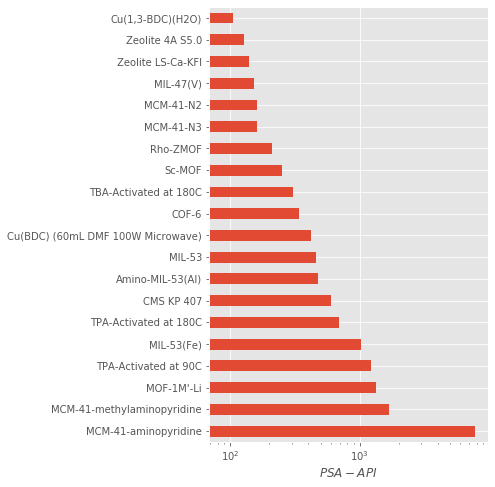

In [143]:
plt.style.use('ggplot')
ax1 = final['KH2/KH1'].nlargest(20).plot.barh(figsize=(5, 8))
ax1.set_ylabel('')
ax1.set_xlabel('$K_{H,2}/K_{H,1}$')
ax1.set_xscale('log')
plt.savefig('./co2-ch4-top10-1.png', bbox_inches='tight', dpi=300)
ax2= final['sel'].nlargest(20).plot.barh(figsize=(5, 8))
ax2.set_ylabel('')
ax2.set_xlabel('$PSA-API$')
ax2.set_xscale('log')
plt.savefig('./co2-ch4-top10-2.png', bbox_inches='tight', dpi=300)